<a href="https://colab.research.google.com/github/Talendar/br_fake_news_detection/blob/main/fake_news_bertimbau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#@title Dependencies and System Info
!pip install -q transformers
!pip install -q nvidia-ml-py3

# Imports
import pandas as pd
import torch
import numpy as np
from timeit import default_timer as timer
from sklearn.metrics import cohen_kappa_score, accuracy_score
from transformers import (BertTokenizer,
                          BertModel,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          BertForSequenceClassification,
                          TrainingArguments,
                          Trainer)
import pynvml
import datetime
import os
import zipfile
import re
from psutil import virtual_memory
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


# System info
pynvml.nvmlInit()
clear_output()

time_limit = datetime.datetime.now() + datetime.timedelta(hours=21)
ram_gb = virtual_memory().total / 1e9

gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
gpu_name = pynvml.nvmlDeviceGetName(gpu_handle)
gpu_memory = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle).total / (2 ** 30)

print(f"CPU cores: {os.cpu_count()}\n"
      f"Total RAM: {ram_gb:.2f} GB\n"
      "-------------------------------\n"
      f"GPU name: {str(gpu_name, 'utf-8')}\n"
      f"GPU memory: {gpu_memory:.2f} GB\n"
      "-------------------------------\n"
      f"Runtime limit: {time_limit.strftime('%d/%m/%Y %H:%M')}")

pynvml.nvmlShutdown()

CPU cores: 4
Total RAM: 27.39 GB
-------------------------------
GPU name: Tesla P100-PCIE-16GB
GPU memory: 15.90 GB
-------------------------------
Runtime limit: 05/04/2021 11:11


### Downloading the data

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus
DATA_PATH = "./Fake.br-Corpus/size_normalized_texts"

### Loading the data

In [4]:
def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return txts


true_txts = load_txts(os.path.join(DATA_PATH, "true"))
fake_txts = load_txts(os.path.join(DATA_PATH, "fake"))
assert(len(true_txts) == len(fake_txts))

data = pd.DataFrame(
    [{"text": t, "label": 0} for t in true_txts] \
         + [{"text": f, "label": 1}  for f in fake_txts]
).sample(frac=1)

pd.set_option('max_colwidth', 200)
display(data)

,text,label
3320,"Por Fausto Macedo, Ricardo Brandt, Fábio Fabrini e Julia Affonso O governador do Acre, Tião Viana (PT), recebeu R$ 300 mil do esquema de propinas e corrupção na Petrobrás para sua campanha em 2010...",0
695,Imagens da semana de 9 a 15 de dezembro de 2017. \n,0
4027,"Rússia, China e Índia prometem lutar ao lado da Coreia do Norte. A RÚSSIA advertiu que o enfrentamento entre os EUA e a Coréia do Norte está prestes a entrar numa fase ""crucial"", à medida que as ...",1
2640,Ex-vice da Caixa reitera à Justiça que recebeu de Cunha propina em dinheiro. Fábio Cleto prestou depoimento nesta sexta (27) em processo que investiga irregularidades em financiamentos do banco. C...,0
3704,"Temer reduz equipe da Lava Jato e corta verba da Polícia Federal. Número de delegados destacados para força-tarefa, em Curitiba, caiu de 9 para 4 e previsão de contingenciamento de 44% do dinheiro...",1
...,...,...
4533,"Lula: ""Vou ganhar as eleições e regular toda a imprensa"". Lula prometeu "" regulamentar (leia-se censurar) os meios de comunicação"" caso seja eleito em 2018. Talvez censurar não seja a palavra ce...",1
4952,Centenas de tanques chineses se deslocam para a fronteira com a Coreia do Norte. . Um vídeo impressionante mostra um comboio inacabável de tanques chineses transportando mísseis em direção à fron...,1
5440,"Os principais beneficiários de repasses da Odebrecht e seus respectivos codinomes – Parte 3. . Continuando a saga da lista de beneficiários da empreiteira, aparecem os seguintes nomes: BABEL Ged...",1
1390,"China pede para EUA e Coreia do Norte conterem o tom de declarações. Presidente da China, Xi Jinping, conversou por telefone com Donald Trump neste sábado. . O presidente da China, Xi Jinping, ped...",0


### Exploring the data

In [5]:
sample = data.sample(n=1)
print("> TEXT: \n{}".format(sample["text"].values[0]))
print("> LABEL: {}".format(sample["label"].values[0]))

> TEXT: 
45ª edição do Festival de Cinema de Gramado exibirá 44 filmes na mostra competitiva. Mostra de cinema inicia nesta quinta-feira (17) e vai até o próximo sábado (26), na cidade da serra gaúcha.. No ano em que celebra 45 anos de história, o Festival de Cinema de Gramado ganha também um dia a mais. A edição de 2017 terá início nesta quinta-feira (17) e vai até o próximo sábado (26), na cidade da Serra do Rio Grande do Sul. O primeiro dia terá a mostra das produções audiovisuais realizadas por alunos da rede pública de Gramado, através do projeto Educavídeo. A competição oficial começa na sexta (16), logo após a exibição hors-concours do longa convidado "João, o Maestro", de Mauro Lima. Ao longo dos 10 dias, serão exibidos 44 filmes, entre curtas e longas-metragens, nacionais e estrangeiros, no telão do Palácio dos Festivais, na disputa pelos kikitos ( confira abaixo a lista completa ). Sete títulos concorrem na categoria nacional. "Acho que fomos aprendendo que não somos nós quem

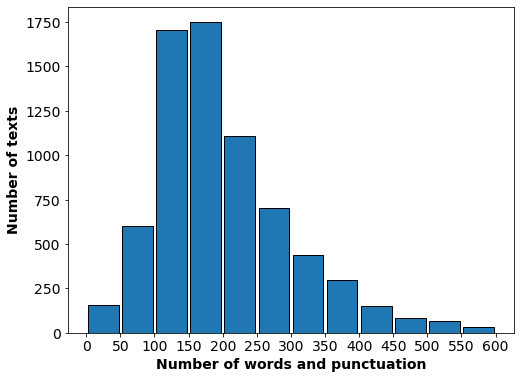

In [9]:
def count_words(texts):
    counts = []
    for text in texts:
        num_words = len(re.findall(r"[\w']+|[.,!?;:/\"]", text))
        counts.append(num_words)
    return np.array(counts)


counts = count_words(data["text"].values)
intervals = list(range(0, 601, 50))

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.hist(counts, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervals)
plt.xticks(intervals)

plt.xlabel("Number of words and punctuation", fontsize=14, fontweight="bold")
plt.ylabel("Number of texts", fontsize=14, fontweight="bold");

### Splitting the data

In [12]:
DATA_SPLIT_PC = [0.75, 0.125, 0.125]
assert sum(DATA_SPLIT_PC) == 1

train_df = data.sample(frac=DATA_SPLIT_PC[0])
val_df = data.drop(train_df.index).sample(n=int(len(data) * DATA_SPLIT_PC[1]))
test_df = data.drop(train_df.index).drop(val_df.index)

print("> Training samples: %d" % len(train_df))
print("> Validation samples: %d" % len(val_df))
print("> Test samples: %d" % len(test_df))

> Training samples: 5400
> Validation samples: 900
> Test samples: 900


### Making the datasets compatible with BERT

In [13]:
# BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased",
                                               do_lower_case=False)

In [14]:
class BertFakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer=bert_tokenizer, max_seq_length=512):
        self._labels = torch.tensor(df["label"].values, dtype=torch.long)
        self._encodings = {"input_ids": [],
                           "token_type_ids": [],
                           "attention_mask": []}

        for txt in df["text"].values:
            enc_dict = tokenizer.encode_plus(
                text=txt,
                add_special_tokens=True,
                max_length=max_seq_length,
                return_token_type_ids=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt",
                truncation=True,
            )
            for k, v in enc_dict.items():
                self._encodings[k].append(v[0])
    
    def __getitem__(self, idx):
        item = {key: value[idx] for key, value in self._encodings.items()}
        item["labels"] = self._labels[idx]
        return item

    def __len__(self):
        return len(self._labels)

In [15]:
train_ds = BertFakeNewsDataset(train_df)
val_ds = BertFakeNewsDataset(val_df)
test_ds = BertFakeNewsDataset(test_df)

In [16]:
train_ds[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

### Loading a BERT model

In [17]:
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=2,
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [21]:
sample = {k: torch.unsqueeze(v, 0)
          for k, v in train_ds[0].items()}

start_time = timer()
print(f"Output: {model(**sample)}")
print(f"Time: {timer() - start_time:.5f}s")

Output: SequenceClassifierOutput(loss=tensor(0.6572, grad_fn=<NllLossBackward>), logits=tensor([[-0.0115,  0.0618]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
Time: 0.76128s


### Training the model

In [47]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "qwk": cohen_kappa_score(labels, predictions, weights="quadratic"),
    }

In [48]:
train_args = TrainingArguments(
    output_dir="drive/MyDrive/Colab Notebooks/saved_models/fake_news_bertimbau",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=10,
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Runtime,Samples Per Second
1,No log,0.121561,0.982222,0.964408,15.979200,56.323000
2,0.016000,0.037312,0.993333,0.986661,15.975900,56.335000
3,0.010600,0.070619,0.987778,0.975534,15.979300,56.323000
4,0.010600,0.058796,0.991111,0.982214,15.976500,56.333000
5,0.003300,0.066941,0.992222,0.984438,15.989300,56.288000
6,0.001400,0.045328,0.995556,0.991107,15.986000,56.299000
7,0.001400,0.040786,0.995556,0.991107,15.981700,56.315000
8,0.002000,0.048286,0.993333,0.986664,15.992100,56.278000
9,0.000000,0.044873,0.995556,0.991107,15.977600,56.329000
10,0.000000,0.044851,0.995556,0.991107,15.985600,56.301000


TrainOutput(global_step=3380, training_loss=0.004931363634373883, metrics={'train_runtime': 3126.2495, 'train_samples_per_second': 1.081, 'total_flos': 1.8069296320512e+16, 'epoch': 10.0, 'init_mem_cpu_alloc_delta': 2227938, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 5598044, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1593087, 'train_mem_gpu_alloc_delta': 1307201024, 'train_mem_cpu_peaked_delta': 92179989, 'train_mem_gpu_peaked_delta': 12561757696})

### Evaluating the model

In [50]:
trainer.evaluate(train_ds)

{'epoch': 10.0,
 'eval_accuracy': 0.9996296296296296,
 'eval_loss': 0.0008772521396167576,
 'eval_mem_cpu_alloc_delta': 158094,
 'eval_mem_cpu_peaked_delta': 466064,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 579153408,
 'eval_qwk': 0.9992592364978019,
 'eval_runtime': 95.8568,
 'eval_samples_per_second': 56.334}

In [51]:
trainer.evaluate(val_ds)

{'epoch': 10.0,
 'eval_accuracy': 0.9955555555555555,
 'eval_loss': 0.045327942818403244,
 'eval_mem_cpu_alloc_delta': 72877,
 'eval_mem_cpu_peaked_delta': 282007,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 579063808,
 'eval_qwk': 0.9911067633065054,
 'eval_runtime': 15.9868,
 'eval_samples_per_second': 56.297}

In [52]:
trainer.evaluate(test_ds)

{'epoch': 10.0,
 'eval_accuracy': 0.9922222222222222,
 'eval_loss': 0.055976640433073044,
 'eval_mem_cpu_alloc_delta': 71500,
 'eval_mem_cpu_peaked_delta': 281867,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 579063808,
 'eval_qwk': 0.9844125768237285,
 'eval_runtime': 15.9915,
 'eval_samples_per_second': 56.28}

### Saving the best model and generating PDF report

In [53]:
model.save_pretrained("drive/MyDrive/Colab Notebooks/saved_models/fake_news_bertimbau/best_model")

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "drive/MyDrive/Colab Notebooks/fake_news_bertimbau.ipynb"